This file only runs the K nearest neighbors implemented by us and by sklearn with SMOTE oversampling. \
This code need "cleaned_K8.csv" in the same direcrory. "cleaned_K8.csv" is get from clean_data.py.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from matplotlib import pyplot
from numpy import where
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score

### Preprocess the imbalanced dataset

In [2]:
# process the imbalanced data
# method is either 'smote' or 'default'
def process_imb(df, testSize, method):
    X,y = SplitData(df) #X, y are pd.DataFrame
    counter = Counter(y.values.ravel().tolist())
    print("count labels on y:",counter)
    
    # use train_test_split function to randomly split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 1234)
    counter = Counter(y_train.values.ravel().tolist())
    print("count labels on y_train:",counter)
    counter = Counter(y_test.values.ravel().tolist())
    print("count labels on y_test:",counter)

    # define pipeline
    over = SMOTE(sampling_strategy = 0.1)
    under = RandomUnderSampler(sampling_strategy = 0.5)
    Pipeline_steps = [('o', over), ('u', under)]
    pipeline = Pipeline(Pipeline_steps)
    if method == 'smote':
        pipeline = over

    X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train)
    counter = Counter(y_train_smote.values.ravel().tolist())
    print("count labels on y_train_smote:",counter)

    return X_train_smote, y_train_smote, X_test, y_test

### Implement KNN from skratch

In [3]:
# splitData is a function that takes a dataframe df, and return the X dataset and y dataset
def SplitData(df): 
    X = df.iloc[:,:5408]
    y = df.iloc[:,5408:5409]
    return X, y

In [4]:
def EuclideanDistance(s1,s2):
    x1,y1 = SplitData(s1)
    x2,y2 = SplitData(s2)
    dist = np.sqrt(np.sum(np.square(x1.values - x2.values)))
    return dist

In [5]:
def GetNeighbors(df_train, df_test, k_num):
    distances = []
    for i in range(len(df)):
        train = df.iloc[i:i+1,:]
        dist = EuclideanDistance(train, df_test)
        distances.append((train, dist))
    distances.sort(key=lambda tup: tup[1]) # sort based on dist
    neighbors = [] 
    for i in range(k_num):
        neighbors.append(distances[i][0])
    return neighbors

In [6]:
def FindMajorityLabel(List):
    return max(set(List), key = List.count)

In [7]:
def MakePrediction(df_train, test, k_num):
    neighbors = GetNeighbors(df_train, test, k_num)       #get k_num neighbors of test dataset
    neighbor_values = [n.iloc[0,5408] for n in neighbors] #get label of each neighbor
    prediction = FindMajorityLabel(neighbor_values)       #make prediction based on majority label in neighbors
    return prediction

In [8]:
def GetLabels(df, k_num, train_size):
    labels = []                            # save predict label and true label in a matrix
    len_train = int(train_size*len(df))
    df_train = df.iloc[:len_train,:]
    df_test = df.iloc[len_train:,:]
    for i in range(len(df_test)):
        test = df_test.iloc[i:i+1,:]
        y_pred = MakePrediction(df_train,test,k_num)
        y_true = df_test.iloc[i,5408]
        labels.append((y_true,y_pred))
    return labels

In [9]:
def GetLabels2(k_num, df_train, df_test):
    labels = []                            # save predict label and true label in a matrix
    for i in range(len(df_test)):
        test = df_test.iloc[i:i+1,:]
        y_pred = MakePrediction(df_train,test,k_num)
        y_true = df_test.iloc[i,5408]
        labels.append((y_true,y_pred))
    return labels

In [10]:
def ComputeAcc(labels):
    total = len(labels)
    correct = 0
    for y in labels:
        if y[0] == y[1]:
            correct += 1
    acc = correct/total
    return acc

### Use KNN from sklearn

In [11]:
def confusionMatrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [12]:
def KNN(df, k_num, train_size):
    labels = GetLabels(df,k_num, train_size)
    acc_knn = ComputeAcc(labels)
    print("accuracy:",acc_knn)
    y_true = np.array(labels)[:,0]
    y_pred = np.array(labels)[:,1]
    precision = precision_score(y_true, y_pred)
    print("precision score:", precision)
    recall= recall_score(y_true, y_pred)
    print("recall score:",recall)
    f1 = f1_score(y_true, y_pred)
    print("f1 score:",f1)
    roc_auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC score", roc_auc)
    confusionMatrix(y_true, y_pred)
    return acc_knn

In [59]:
def KNN_smote_undersampling(df, k_num, test_size, method):
    X_train_smote, y_train_smote, X_test, y_test = process_imb(df, 0.3, method)
    df_train = pd.concat([X_train_smote, y_train_smote], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    labels = GetLabels2(k_num, df_train, df_test)
    y_true = np.array(labels)[:,0]
    y_pred = np.array(labels)[:,1]
    acc_knn = accuracy_score(y_pred, y_true)
    print("accuracy:",acc_knn)
    precision = precision_score(y_true, y_pred)
    print("precision score:", precision)
    recall= recall_score(y_true, y_pred)
    print("recall score:",recall)
    f1 = f1_score(y_true, y_pred)
    print("f1 score:",f1)
    roc_auc = roc_auc_score(y_true, y_pred)
    print("ROC AUC score", roc_auc)
    confusionMatrix(y_true, y_pred)
    return acc_knn

accuracy: 0.9895540377661711
precision score: 1.0
recall score: 0.037037037037037035
f1 score: 0.07142857142857142
ROC AUC score 0.5185185185185185


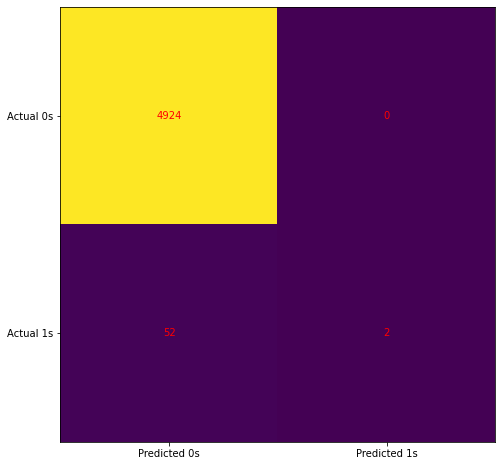

In [149]:
acc_knn = KNN(df, 5, 0.7)

count labels on y: Counter({0: 16449, 1: 143})
count labels on y_train: Counter({0: 11517, 1: 97})
count labels on y_test: Counter({0: 4932, 1: 46})
count labels on y_train_smote: Counter({0: 11517, 1: 1151})
accuracy: 0.9823222177581358
precision score: 0.21621621621621623
recall score: 0.34782608695652173
f1 score: 0.26666666666666666
ROC AUC score 0.6680330759194612


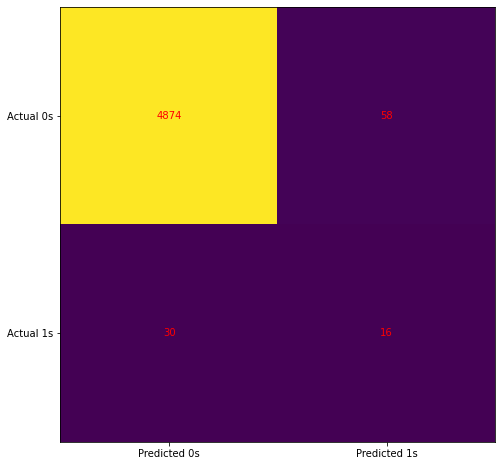

In [155]:
acc_knn = KNN_smote_undersampling(df, 5, 0.3, 'smote') # SMOTE oversampling

count labels on y: Counter({0: 16449, 1: 143})
count labels on y_train: Counter({0: 11517, 1: 97})
count labels on y_test: Counter({0: 4932, 1: 46})
count labels on y_train_smote: Counter({0: 2302, 1: 1151})
accuracy: 0.9433507432703897
precision score: 0.07857142857142857
recall score: 0.4782608695652174
f1 score: 0.1349693251533742
ROC AUC score 0.7129747170210515


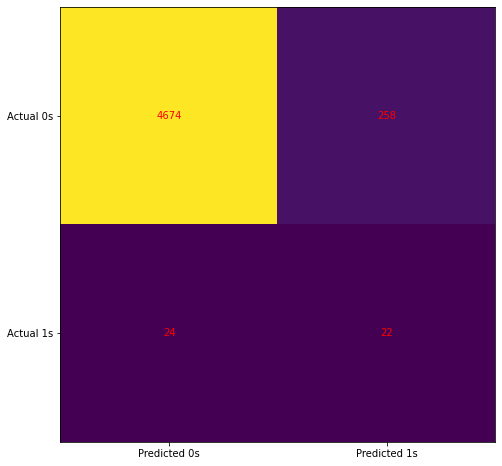

In [150]:
acc_knn = KNN_smote_undersampling(df, 5, 0.3, 'mix') #SMOTE + Random Undersampling

### Which k is the best?

get accurancy when k = 3,5,7,9,...,27

In [3]:
def get_accs(k,train_size):
    df = pd.read_csv("cleaned_K8.csv", header = None)
    accs = []
    for i in range(1,20):
        k = 2*i + 1
        print(k)
        acc_knn = KNN(df,k,train_size)
        print(acc_knn)
        accs.append(acc_knn)
    return accs

In [4]:
def k_tunning_plot(accs):
    x = [2*i+1 for i in range(1,20)]
    y = accs

    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy score as the K goes up')

    plt.plot(x,y)

    plt.show()

In [ ]:
accs = get_accs(5, 0.7)
k_tunning_plot(accs)